# Hello, KAN!

### Kolmogorov-Arnold representation theorem

Kolmogorov-Arnold representation theorem states that if $f$ is a multivariate continuous function
on a bounded domain, then it can be written as a finite composition of continuous functions of a
single variable and the binary operation of addition. More specifically, for a smooth $f : [0,1]^n \to \mathbb{R}$,


$$f(x) = f(x_1,...,x_n)=\sum_{q=1}^{2n+1}\Phi_q(\sum_{p=1}^n \phi_{q,p}(x_p))$$

where $\phi_{q,p}:[0,1]\to\mathbb{R}$ and $\Phi_q:\mathbb{R}\to\mathbb{R}$. In a sense, they showed that the only true multivariate function is addition, since every other function can be written using univariate functions and sum. However, this 2-Layer width-$(2n+1)$ Kolmogorov-Arnold representation may not be smooth due to its limited expressive power. We augment its expressive power by generalizing it to arbitrary depths and widths.

### Kolmogorov-Arnold Network (KAN)

The Kolmogorov-Arnold representation can be written in matrix form

$$f(x)={\bf \Phi}_{\rm out}\circ{\bf \Phi}_{\rm in}\circ {\bf x}$$

where 

$${\bf \Phi}_{\rm in}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n}(\cdot) \\ \vdots & & \vdots \\ \phi_{2n+1,1}(\cdot) & \cdots & \phi_{2n+1,n}(\cdot) \end{pmatrix},\quad {\bf \Phi}_{\rm out}=\begin{pmatrix} \Phi_1(\cdot) & \cdots & \Phi_{2n+1}(\cdot)\end{pmatrix}$$

We notice that both ${\bf \Phi}_{\rm in}$ and ${\bf \Phi}_{\rm out}$ are special cases of the following function matrix ${\bf \Phi}$ (with $n_{\rm in}$ inputs, and $n_{\rm out}$ outputs), we call a Kolmogorov-Arnold layer:

$${\bf \Phi}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n_{\rm in}}(\cdot) \\ \vdots & & \vdots \\ \phi_{n_{\rm out},1}(\cdot) & \cdots & \phi_{n_{\rm out},n_{\rm in}}(\cdot) \end{pmatrix}$$

${\bf \Phi}_{\rm in}$ corresponds to $n_{\rm in}=n, n_{\rm out}=2n+1$, and ${\bf \Phi}_{\rm out}$ corresponds to $n_{\rm in}=2n+1, n_{\rm out}=1$.

After defining the layer, we can construct a Kolmogorov-Arnold network simply by stacking layers! Let's say we have $L$ layers, with the $l^{\rm th}$ layer ${\bf \Phi}_l$ have shape $(n_{l+1}, n_{l})$. Then the whole network is

$${\rm KAN}({\bf x})={\bf \Phi}_{L-1}\circ\cdots \circ{\bf \Phi}_1\circ{\bf \Phi}_0\circ {\bf x}$$

In constrast, a Multi-Layer Perceptron is interleaved by linear layers ${\bf W}_l$ and nonlinearities $\sigma$:

$${\rm MLP}({\bf x})={\bf W}_{L-1}\circ\sigma\circ\cdots\circ {\bf W}_1\circ\sigma\circ {\bf W}_0\circ {\bf x}$$

A KAN can be easily visualized. (1) A KAN is simply stack of KAN layers. (2) Each KAN layer can be visualized as a fully-connected layer, with a 1D function placed on each edge. Let's see an example below.

### Get started with KANs

Initialize KAN

In [1]:
import torch
torch.set_default_dtype(torch.float64) # 设置默认张量数据类型为双精度浮点数
torch.manual_seed(33) # 设置随机数种子为33

In [3]:
from kan import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 创建一个KAN模型：
# 输入维度为2，输出维度为1，隐藏层有5个神经元
# 使用三次样条（k=3），将输入空间划分为5个网格间隔（grid=5）
# 设置随机数种子为0
# model = KAN(width=[2,5,1], grid=5, k=3, seed=0,device=device)

Create dataset

In [7]:
# 定义数据集函数 f(x,y) = exp(sin(pi*x) + y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
# 使用 create_dataset 函数创建数据集
# 数据集包含两个自变量（n_var=2）
# 数据集会根据设备 device 进行处理
dataset = create_dataset(f, n_var=2,device=device)
# 打印训练输入和标签的形状
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [4]:
dataset

{'train_input': tensor([[ 0.9401,  0.9797],
         [ 0.4156, -0.9600],
         [-0.0812, -0.1531],
         ...,
         [ 0.7357,  0.5217],
         [-0.4637, -0.7196],
         [ 0.5701, -0.4481]], device='cuda:0'),
 'test_input': tensor([[-0.5624,  0.5904],
         [ 0.2209, -0.0834],
         [-0.0159,  0.0811],
         ...,
         [-0.4784,  0.6921],
         [ 0.2671, -0.2259],
         [ 0.2627, -0.0458]], device='cuda:0'),
 'train_label': tensor([[3.1481],
         [6.5976],
         [0.7953],
         [3.4230],
         [3.8323],
         [2.8803],
         [0.4949],
         [0.4471],
         [1.6879],
         [0.7747],
         [1.3055],
         [0.8055],
         [0.4544],
         [2.3354],
         [1.0084],
         [1.1847],
         [1.0150],
         [0.4204],
         [2.3784],
         [2.6542],
         [0.6557],
         [6.4748],
         [0.6450],
         [1.3893],
         [0.3861],
         [1.9856],
         [2.6840],
         [3.1836],
         [

Plot KAN at initialization

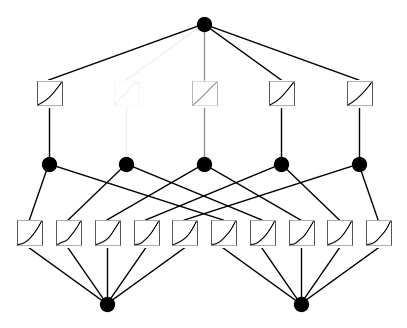

In [4]:
# 绘制初始化时的KAN模型图形
model(dataset['train_input']);
# 使用 plot 方法绘制模型的输出结果
# 设置 beta 参数为 100，用于控制平滑度
model.plot(beta=100)

Train KAN with sparsity regularization

In [5]:
# 对模型进行训练
# 使用 LBFGS 优化器
# 进行 20 步训练
# 设置正则化参数为 0.01
# 设置信息熵正则化参数为 10.0
# 在给定的设备上进行训练
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.,device=device);

train loss: 1.25e-01 | test loss: 1.15e-01 | reg: 1.90e+01 : 100%|██| 20/20 [00:11<00:00,  1.73it/s]


Plot trained KAN

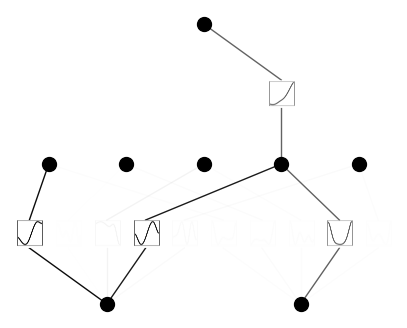

In [6]:
model.plot() # 使用 plot 方法绘制训练后的KAN模型

Prune KAN and replot (keep the original shape)（保持原始形状）

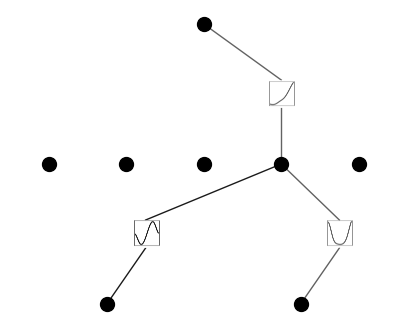

In [7]:
# 对KAN模型进行修剪
model.prune()
# 使用 plot 方法绘制修剪后的KAN模型
# 设置 mask=True 以保持原始形状
model.plot(mask=True)

Prune KAN and replot (get a smaller shape) 
（获得一个较小的形状）

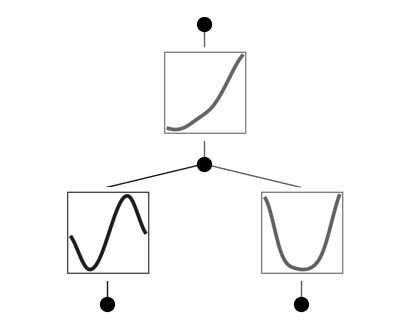

In [8]:
# 修剪KAN模型，并将修剪后的模型重新赋值给原来的模型变量
model = model.prune()
# 使用修剪后的模型对训练输入数据进行预测
model(dataset['train_input'])
# 使用 plot 方法绘制修剪后的KAN模型的输出结果
model.plot()

Continue training and replot

In [9]:
# 继续对模型进行训练
# 使用 LBFGS 优化器
# 进行 50 步训练
# 在给定的设备上进行训练
model.train(dataset, opt="LBFGS", steps=50,device=device);

train loss: 4.72e-03 | test loss: 4.76e-03 | reg: 2.93e+00 : 100%|██| 50/50 [00:17<00:00,  2.84it/s]


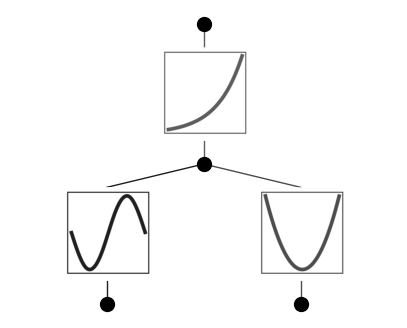

In [10]:
model.plot() # 使用 plot 方法绘制模型的输出结果

Automatically or manually set activation functions to be symbolic
自动或手动设置激活函数为符号函数

In [11]:
# 设置 mode 变量为 "auto" 或 "manual"，以确定激活函数的设置方式
mode = "auto"  # 或者 mode = "manual"
# 如果 mode 是 "manual"，则手动设置激活函数为符号函数
if mode == "manual":
    # 手动模式下，逐个指定隐藏层和输入层的激活函数
    # 第一个参数表示层的索引，第二个和第三个参数表示神经元的索引
    # 第四个参数为要设置的激活函数，例如 'sin', 'x^2', 'exp' 等
    model.fix_symbolic(0,0,0,'sin'); # 设置第一个隐藏层的第一个神经元的激活函数为正弦函数
    model.fix_symbolic(0,1,0,'x^2'); # 设置第一个隐藏层的第二个神经元的激活函数为平方函数
    model.fix_symbolic(1,0,0,'exp'); # 设置输出层的第一个神经元的激活函数为指数函数
# 如果 mode 是 "auto"，则自动设置激活函数为符号函数
elif mode == "auto":
    # 自动模式下，根据提供的激活函数库自动选择合适的符号函数作为激活函数
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999869910535453
fixing (0,1,0) with x^2, r2=0.9999994685844854
fixing (1,0,0) with exp, r2=0.9999988359223907


Continue training to almost machine precision
继续训练，接近机器精度

In [12]:
model.train(dataset, opt="LBFGS",steps=50,device=device); # 继续对模型进行训练

train loss: 2.66e-10 | test loss: 7.60e-11 | reg: 2.93e+00 : 100%|██| 50/50 [00:04<00:00, 11.26it/s]


Obtain the symbolic formula
获取符号化公式

In [13]:
model.symbolic_formula()[0][0] # 获取模型的符号化公式

1.0*exp(1.0*x_2**2 + 1.0*sin(3.14*x_1))